In [ ]:
from proteusPy import Load_PDB_SS, Disulfide, DisulfideList

PDB_SS = Load_PDB_SS(subset=False, verbose=True)
PDB_SS.describe()

In [ ]:
ss1 = PDB_SS["2q7q_75D_140D"]
ss1.QUIET = False
ss1.bond_length_ideality
ss1.bond_angle_ideality

In [ ]:
dihed = ss1.dihedrals
modelled_min = Disulfide("model", quiet=False)
modelled_min.dihedrals = dihed
modelled_min.build_yourself()
modelled_min.bond_length_ideality

In [ ]:
# investigate the distal N->Ca distance. 8/15/24 -egs-

modelled_min.bond_angle_ideality

In [4]:
sslist = PDB_SS.SSList
len(sslist)

175649

In [40]:
import pandas as pd
from tqdm import tqdm


def create_disulfide_dataframe(disulfide_list):
    """
    Create a DataFrame with columns PDB_ID, SS_Name, Angle_Deviation, Distance_Deviation
    from a list of disulfides.

    :param disulfide_list: List of disulfide objects.
    :type proteusPy.DisulfideList: list
    :return: DataFrame containing the disulfide information.
    :rtype: pd.DataFrame
    """
    data = {
        "PDB_ID": [],
        "SS_Name": [],
        "Angle_Deviation": [],
        "Distance_Deviation": [],
        "Ca_Distance": [],
    }

    for ss in tqdm(disulfide_list, desc="Processing Disulfides"):
        pdb_id = ss.pdb_id
        ca_distance = ss.ca_distance
        angle_deviation = ss.bond_angle_ideality
        distance_deviation = ss.bond_length_ideality

        data["PDB_ID"].append(pdb_id)
        data["SS_Name"].append(ss.name)
        data["Angle_Deviation"].append(angle_deviation)
        data["Distance_Deviation"].append(distance_deviation)
        data["Ca_Distance"].append(ca_distance)

    df = pd.DataFrame(data)
    return df


# Example usage
# Assuming you have a list of disulfide objects called disulfide_list
# df = create_disulfide_dataframe(disulfide_list)
# print(df)

In [41]:
dev_df = create_disulfide_dataframe(sslist)

Processing Disulfides:   0%|          | 0/175649 [00:00<?, ?it/s]/Users/egs/miniforge3/envs/ppydev/lib/python3.11/site-packages/proteusPy/vector3D.py:383: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = dot_product / (magnitude1 * magnitude2)
Processing Disulfides: 100%|██████████| 175649/175649 [00:13<00:00, 13214.40it/s]


In [42]:
dev_df.describe()

,Angle_Deviation,Distance_Deviation,Ca_Distance
count,175283.000000,175649.000000,175649.000000
mean,3.176513,0.067374,5.685717
std,3.020882,0.912440,1.953223
min,0.408792,0.004634,0.000000
25%,1.877205,0.023640,5.159000
50%,2.391913,0.026771,5.714048
75%,3.217401,0.031380,6.268046
max,54.257041,157.108446,159.121540


In [43]:
dev_df.head()

,PDB_ID,SS_Name,Angle_Deviation,Distance_Deviation,Ca_Distance
0,6dmb,6dmb_203A_226A,2.836489,0.027686,6.137211
1,6dmb,6dmb_234A_327A,1.692538,0.039996,4.807415
2,6dmb,6dmb_296A_304A,2.092399,0.028735,6.690815
3,3rik,3rik_4A_16A,2.062282,0.027654,5.366827
4,3rik,3rik_18A_23A,4.153849,0.060760,4.635920


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_histograms(df):
    """
    Plot histograms for Distance_Deviation, Angle_Deviation, and Ca_Distance.

    :param df: DataFrame containing the disulfide information.
    :type df: pd.DataFrame
    """
    plt.figure(figsize=(21, 6))

    # Distance Deviation Histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df["Distance_Deviation"], kde=True, bins=30)
    plt.title("Distance Deviation Distribution")
    plt.xlabel("Distance Deviation")
    plt.ylabel("Frequency")

    # Angle Deviation Histogram
    plt.subplot(1, 3, 2)
    sns.histplot(df["Angle_Deviation"], kde=True, bins=30)
    plt.title("Angle Deviation Distribution")
    plt.xlabel("Angle Deviation")
    plt.ylabel("Frequency")

    # Ca_Distance Histogram
    plt.subplot(1, 3, 3)
    sns.histplot(df["Ca_Distance"], kde=True, bins=30)
    plt.title("Ca Distance Distribution")
    plt.xlabel("Ca Distance")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

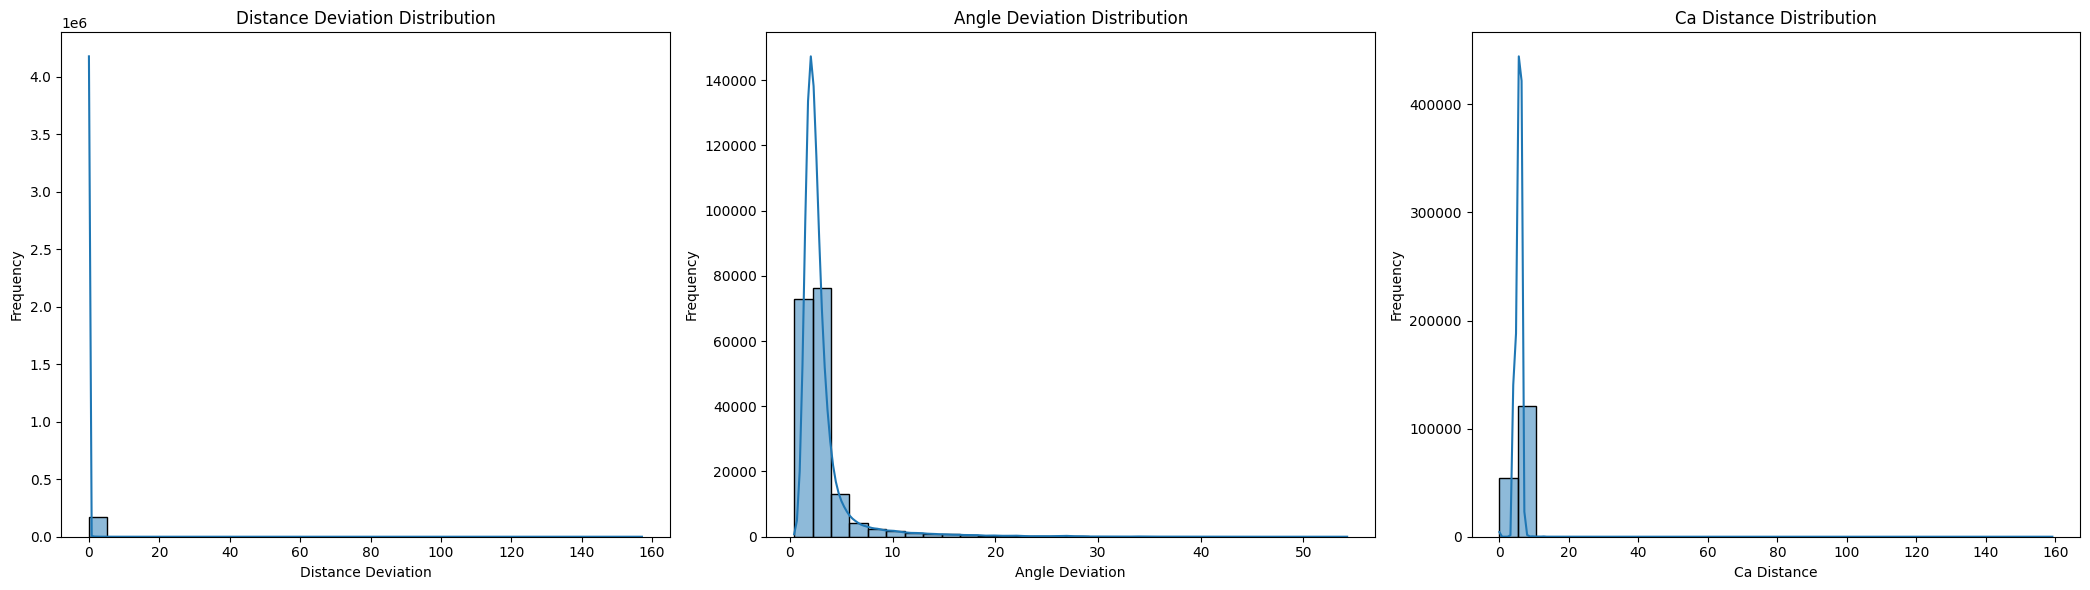

In [50]:
plot_histograms(dev_df)

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns


def highlight_worst_structures(df, top_n=10):
    """
    Highlight the worst structures for distance and angle deviations and annotate their names.
    Also, add a subplot showing the worst structures aggregated by PDB_ID.

    :param df: DataFrame containing the disulfide information.
    :type df: pd.DataFrame
    :param top_n: Number of worst structures to highlight.
    :type top_n: int
    """
    # Identify the worst structures for distance deviation
    worst_distance = df.nlargest(top_n, "Distance_Deviation")

    # Identify the worst structures for angle deviation
    worst_angle = df.nlargest(top_n, "Angle_Deviation")

    # Combine the worst structures
    worst_structures = pd.concat([worst_distance, worst_angle]).drop_duplicates()

    # Aggregate worst structures by PDB_ID
    worst_structures_agg = (
        worst_structures.groupby("PDB_ID").size().reset_index(name="Count")
    )

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Scatter plot for all structures
    sns.scatterplot(
        x="Distance_Deviation",
        y="Angle_Deviation",
        data=df,
        label="All Structures",
        ax=axes[0],
    )

    # Highlight the worst structures
    sns.scatterplot(
        x="Distance_Deviation",
        y="Angle_Deviation",
        data=worst_structures,
        color="red",
        label="Worst Structures",
        marker="X",
        s=100,
        ax=axes[0],
    )

    # Annotate the worst structures with their names
    for i, row in worst_structures.iterrows():
        axes[0].annotate(
            row["SS_Name"],
            (row["Distance_Deviation"], row["Angle_Deviation"]),
            textcoords="offset points",
            xytext=(5, 5),
            ha="right",
        )

    axes[0].set_title("Distance Deviation vs. Angle Deviation")
    axes[0].set_xlabel("Distance Deviation")
    axes[0].set_ylabel("Angle Deviation")
    axes[0].legend()

    # Bar plot for worst structures aggregated by PDB_ID
    sns.barplot(x="PDB_ID", y="Count", data=worst_structures_agg, ax=axes[1])
    axes[1].set_title("Worst Structures Aggregated by PDB_ID")
    axes[1].set_xlabel("PDB_ID")
    axes[1].set_ylabel("Count")
    axes[1].tick_params(axis="x", rotation=90)

    plt.tight_layout()
    plt.show()


# Example usage
# Assuming you have a DataFrame named dev_df
# highlight_worst_structures(dev_df, top_n=10)

ValueError: Could not interpret value `CA_Distance` for `x`. An entry with this name does not appear in `data`.

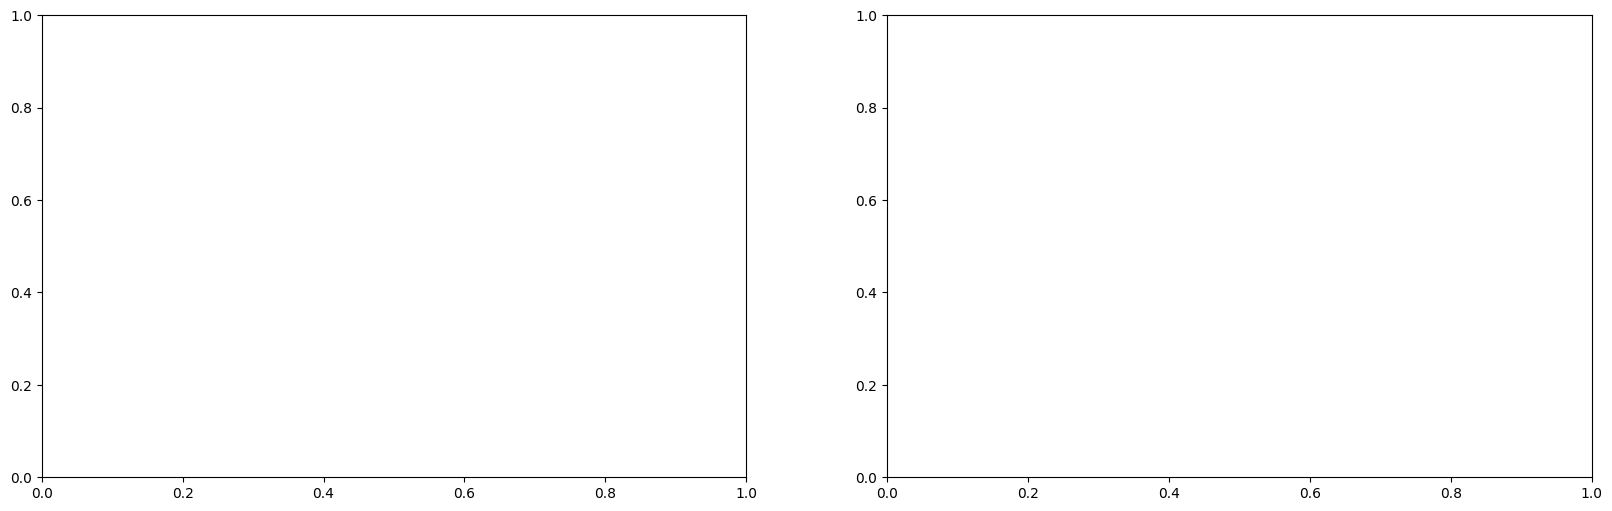

In [51]:
highlight_worst_structures(dev_df, top_n=10)

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns


def highlight_worst_structures2(df, top_n=10):
    """
    Highlight the worst structures for distance and angle deviations and annotate their names.
    Also, add subplots showing the worst structures aggregated by PDB_ID for distance and angle deviations.

    :param df: DataFrame containing the disulfide information.
    :type df: pd.DataFrame
    :param top_n: Number of worst structures to highlight.
    :type top_n: int
    """
    # Identify the worst structures for distance deviation
    worst_distance = df.nlargest(top_n, "Distance_Deviation")

    # Identify the worst structures for angle deviation
    worst_angle = df.nlargest(top_n, "Angle_Deviation")

    # Combine the worst structures
    worst_structures = pd.concat([worst_distance, worst_angle]).drop_duplicates()

    # Aggregate worst structures by PDB_ID for distance and angle deviations
    worst_distance_agg = (
        worst_distance.groupby("PDB_ID").size().reset_index(name="Count")
    )
    worst_angle_agg = worst_angle.groupby("PDB_ID").size().reset_index(name="Count")

    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    # Histogram for distance deviation
    sns.histplot(df["Distance_Deviation"], kde=True, bins=30, ax=axes[0])
    axes[0].set_title("Distance Deviation Distribution")
    axes[0].set_xlabel("Distance Deviation")
    axes[0].set_ylabel("Frequency")

    # Histogram for angle deviation
    sns.histplot(df["Angle_Deviation"], kde=True, bins=30, ax=axes[1])
    axes[1].set_title("Angle Deviation Distribution")
    axes[1].set_xlabel("Angle Deviation")
    axes[1].set_ylabel("Frequency")

    # Bar plots for worst structures aggregated by PDB_ID
    sns.barplot(
        x="PDB_ID",
        y="Count",
        data=worst_distance_agg,
        ax=axes[2],
        color="blue",
        label="Distance Deviation",
    )
    sns.barplot(
        x="PDB_ID",
        y="Count",
        data=worst_angle_agg,
        ax=axes[2],
        color="green",
        label="Angle Deviation",
        alpha=0.6,
    )
    axes[2].set_title("Worst Structures Aggregated by PDB_ID")
    axes[2].set_xlabel("PDB_ID")
    axes[2].set_ylabel("Count")
    axes[2].tick_params(axis="x", rotation=90)
    axes[2].legend()

    plt.tight_layout()
    plt.show()


# Example usage
# Assuming you have a DataFrame named dev_df
# highlight_worst_structures(dev_df, top_n=10)

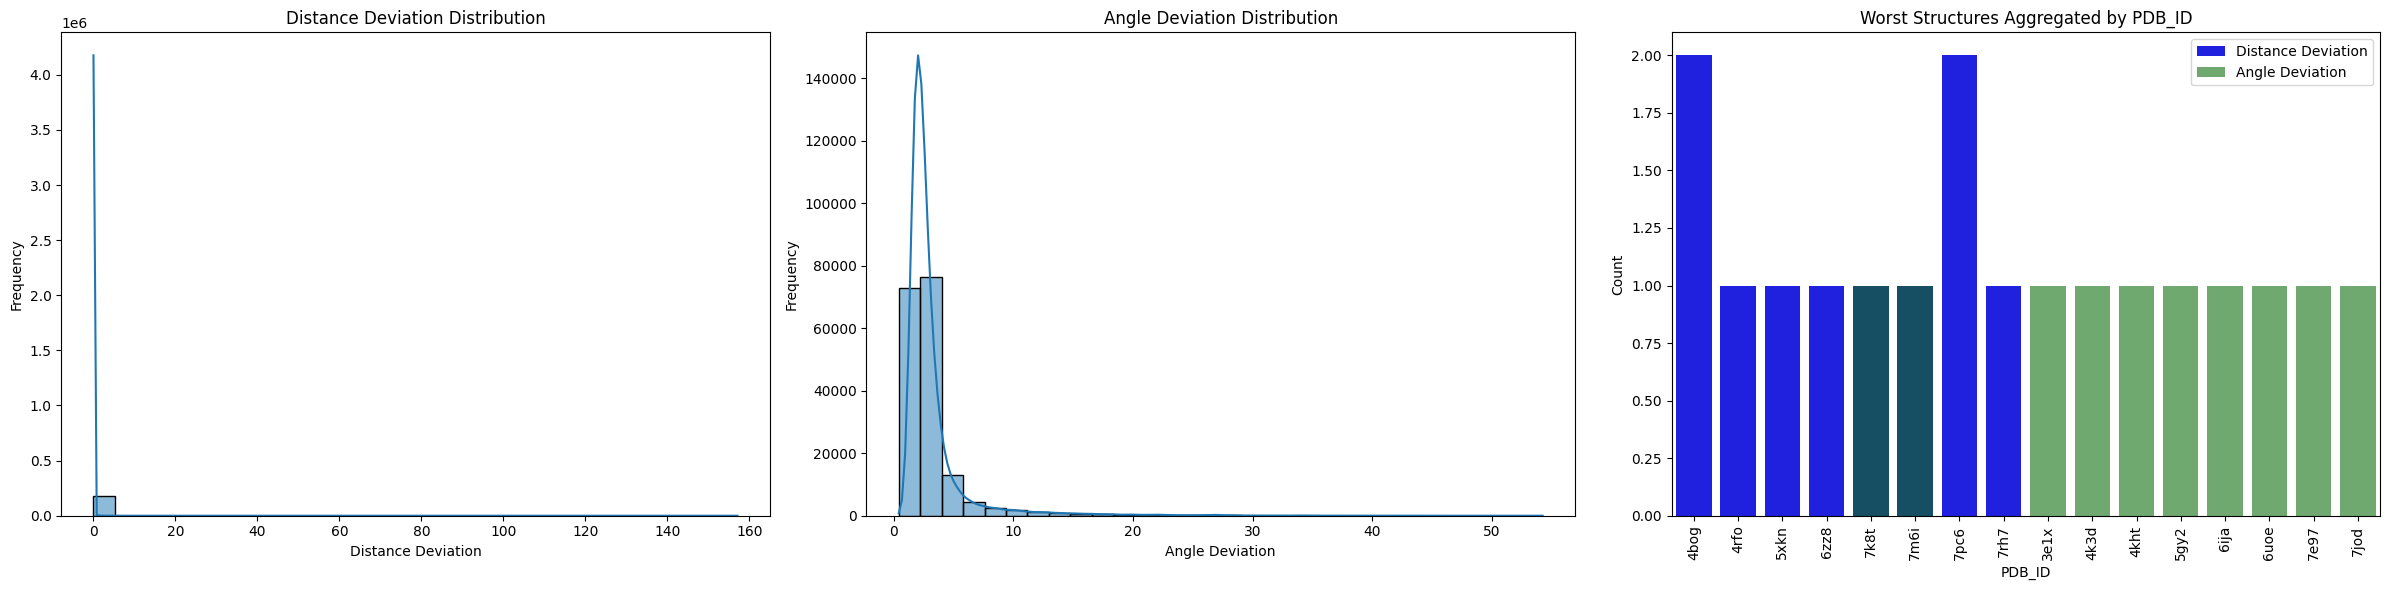

In [53]:
highlight_worst_structures2(dev_df, top_n=10)

In [54]:
import pandas as pd
import numpy as np


def calculate_std_cutoff(df, column, num_std=2):
    """
    Calculate cutoff based on standard deviation.

    :param df: DataFrame containing the deviations.
    :type df: pd.DataFrame
    :param column: Column name for which to calculate the cutoff.
    :type column: str
    :param num_std: Number of standard deviations to use for the cutoff.
    :type num_std: int
    :return: Cutoff value.
    :rtype: float
    """
    mean = df[column].mean()
    std = df[column].std()
    cutoff = mean + num_std * std
    return cutoff


def calculate_percentile_cutoff(df, column, percentile=95):
    """
    Calculate cutoff based on percentile.

    :param df: DataFrame containing the deviations.
    :type df: pd.DataFrame
    :param column: Column name for which to calculate the cutoff.
    :type column: str
    :param percentile: Percentile to use for the cutoff.
    :type percentile: int
    :return: Cutoff value.
    :rtype: float
    """
    cutoff = np.percentile(df[column].dropna(), percentile)
    return cutoff


# Example usage
# distance_cutoff = calculate_percentile_cutoff(dev_df, 'Distance_Deviation', percentile=95)
# angle_cutoff = calculate_percentile_cutoff(dev_df, 'Angle_Deviation', percentile=95)

In [58]:
import pandas as pd
import numpy as np

# Assuming you have a DataFrame named dev_df with columns 'Distance_Deviation' and 'Angle_Deviation'

# Standard Deviation Method
distance_cutoff_std = calculate_std_cutoff(dev_df, "Distance_Deviation", num_std=3)
angle_cutoff_std = calculate_std_cutoff(dev_df, "Angle_Deviation", num_std=3)
ca_cutoff_std = calculate_std_cutoff(dev_df, "Ca_Distance", num_std=3)

# Percentile Method
distance_cutoff_percentile = calculate_percentile_cutoff(
    dev_df, "Distance_Deviation", percentile=98
)
angle_cutoff_percentile = calculate_percentile_cutoff(
    dev_df, "Angle_Deviation", percentile=98
)
ca_cutoff_percentile = calculate_percentile_cutoff(dev_df, "Ca_Distance", percentile=98)

print(f"Distance Deviation Cutoff (3 Std Dev): {distance_cutoff_std}")
print(f"Angle Deviation Cutoff (3 Std Dev): {angle_cutoff_std}")
print(f"Ca Distance Cutoff (3 Std Dev): {ca_cutoff_std}\n")

print(f"Distance Deviation Cutoff (98th Percentile): {distance_cutoff_percentile}")
print(f"Angle Deviation Cutoff (98th Percentile): {angle_cutoff_percentile}")
print(f"Ca Distance Cutoff (98th Percentile): {ca_cutoff_percentile}")

Distance Deviation Cutoff (3 Std Dev): 2.8046945077556846
Angle Deviation Cutoff (3 Std Dev): 12.239159878700725
Ca Distance Cutoff (3 Std Dev): 11.545385755535374

Distance Deviation Cutoff (98th Percentile): 0.21408618233511978
Angle Deviation Cutoff (98th Percentile): 13.286981163171147
Ca Cutoff (98th Percentile): 6.882876764840177


In [27]:
import pandas as pd


def filter_by_cutoffs(df, distance_cutoff, angle_cutoff):
    """
    Filter the DataFrame based on distance and angle cutoffs.

    :param df: DataFrame containing the deviations.
    :type df: pd.DataFrame
    :param distance_cutoff: Cutoff value for distance deviation.
    :type distance_cutoff: float
    :param angle_cutoff: Cutoff value for angle deviation.
    :type angle_cutoff: float
    :return: Filtered DataFrame.
    :rtype: pd.DataFrame
    """
    filtered_df = df[
        (df["Distance_Deviation"] <= distance_cutoff)
        & (df["Angle_Deviation"] <= angle_cutoff)
    ]
    return filtered_df


# Example usage
# Assuming you have a DataFrame named dev_df
# distance_cutoff = 5.0
# angle_cutoff = 10.0
# filtered_df = filter_by_cutoffs(dev_df, distance_cutoff, angle_cutoff)
# print(filtered_df)

In [32]:
dev_df.shape[0]

175649

In [35]:
filt = filter_by_cutoffs(dev_df, 1.0, 10.0)
filt.shape[0]

169329

168280

In [30]:
dev_df.shape[0]

175649

In [38]:
print(dev_df["Angle_Deviation"].isna().sum())

366


In [39]:
import pandas as pd
import numpy as np


def calculate_std_cutoff(df, column, num_std=2):
    mean = df[column].mean()
    std = df[column].std()
    cutoff = mean + num_std * std
    return cutoff


def calculate_percentile_cutoff(df, column, percentile=95):
    cutoff = np.percentile(df[column].dropna(), percentile)
    return cutoff


# Assuming you have a DataFrame named dev_df with columns 'Distance_Deviation' and 'Angle_Deviation'

# Check for missing values
print(f"Missing values in 'Angle_Deviation': {dev_df['Angle_Deviation'].isna().sum()}")

# Drop missing values for the calculation
dev_df = dev_df.dropna(subset=["Angle_Deviation", "Distance_Deviation"])

# Standard Deviation Method
distance_cutoff_std = calculate_std_cutoff(dev_df, "Distance_Deviation", num_std=3)
angle_cutoff_std = calculate_std_cutoff(dev_df, "Angle_Deviation", num_std=3)

# Percentile Method
distance_cutoff_percentile = calculate_percentile_cutoff(
    dev_df, "Distance_Deviation", percentile=98
)
angle_cutoff_percentile = calculate_percentile_cutoff(
    dev_df, "Angle_Deviation", percentile=98
)

print(f"Distance Deviation Cutoff (3 Std Dev): {distance_cutoff_std}")
print(f"Angle Deviation Cutoff (3 Std Dev): {angle_cutoff_std}")
print(f"Distance Deviation Cutoff (98th Percentile): {distance_cutoff_percentile}")
print(f"Angle Deviation Cutoff (98th Percentile): {angle_cutoff_percentile}")

Missing values in 'Angle_Deviation': 366
Distance Deviation Cutoff (3 Std Dev): 2.7458174131016695
Angle Deviation Cutoff (3 Std Dev): 12.239159878700725
Distance Deviation Cutoff (98th Percentile): 0.18644304625827546
Angle Deviation Cutoff (98th Percentile): 13.286981163171147
